# 8- MÉTRICAS

 La rápida expansión de NILM y el desarrollo de diferentes algoritmos, han hecho que sea esencial proporcionar una evaluación de rendimiento mediante el uso de métricas de desempeño. Las métricas de evaluación, comparan los resultados de la desagregaciónn (predicciones) de los modelos entrenados con los datos del set de validación (mediciones reales de cada proceso). NILMTK cuenta con el cálculo de métricas de evaluación mediante el uso del MeterGroup para la validación de los resultados mediante el set de validación 
 Vamos ahora analizar en nuestro dataset diferentes metricas como son FEAC,F1, EAE ,MNEAP y RMSE  que  resumimos a continuacion en el siguinte cuadro:

![metricas](metricas.jpg)

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

### Métricas individuales del modelo

In [47]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

In [48]:


labels = pd.DataFrame({'Instances': list(range(1,12)),
                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Kettle','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})



 

#Set para validación
valid = DataSet('dsual.h5')
valid.set_window(start="2023-03-07 12:10:38", end="2023-03-07 12:41:26")

valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
print(valid_Devices)






index = list(labels['Meters'][1:11])
met = []
e = []


#dataset=DataSet(data_dir+'NILM/Results/FHMM_60s_mean_pred.h5')
#Electric furnace	Microwave	Television	Kettle	Vacuum cleaner	Electric space heater	Electric shower heater	Fan	Fridge	Freezer
#F1	0.229	0.000	0.556	0.154	0.176	0.176	0.200	0.621	0.370	0.410
#dataset=DataSet(data_dir+'NILM/Results/FHMM_60s_median_pred.h5')
#	0.229	0.062	0.588	0.121	0.176	0.176	0.154	0.538	0.591	0.410
dataset=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
#Electric furnace	Microwave	Television	Kettle	Vacuum cleaner	Electric space heater	Electric shower heater	Fan	Fridge	Freezer
#F1	0.229	0.062	0.606	0.121	0.176	0.176	0.143	0.519	0.591	0.410


predictions=dataset.buildings[1].elec.submeters()      

#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)

for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e
#da error esta medida AttributeError: 'tuple' object has no attribute 'instance'
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DSUAL', appliances=[Appliance(type='electric shower heater', instance=1)])
  ElecMeter(instance=9, buildin

,Electric furnace,Microwave,Television,Kettle,Vacuum cleaner,Electric space heater,Electric shower heater,Fan,Fridge,Freezer
F1,0.229,0.062,0.606,0.121,0.176,0.176,0.143,0.519,0.591,0.410
EAE,0.075,0.101,0.004,0.034,0.037,0.092,0.097,0.001,0.010,0.007
MNEAP,1.185,3.618,0.576,1.714,2.094,1.258,2.275,0.623,0.664,0.742
RMSE,741.078,312.333,20.633,546.773,218.454,896.857,733.203,17.190,34.146,28.029


Carga de datos de predicciones y GT en memoria

In [49]:
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'mean'})


labels = pd.DataFrame({'Instances': list(range(1,12)),
                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Kettle','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})



Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]
    

    
    
#resultados de predicción modelo CO 30s
CO_30s_mean=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
elec_CO_30s_mean=CO_30s_mean.buildings[1].elec

#resultados de predicción modelo FHMM 30s
FHMM_30s_mean=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
elec_FHMM_30s_mean= FHMM_30s_mean.buildings[1].elec    
    
    

gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_mean.dataframe_of_meters(ac_type='active')

pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:12]

pred_FHMM=elec_FHMM_30s_mean.dataframe_of_meters(ac_type='active')

pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:12]

### Análisis particular del cálculo de cada métrica

Metrica FEAC ( da problema con AttributeError: 'tuple' object has no attribute 'instance')

In [50]:
#Carga de datos de predicciones y GT en memoria
#gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
#gt.columns=list(Meters.values())

In [51]:
#predictions_Devices=elec_CO_60s_first.submeters()

#frac_1 = valid_Devices.fraction_per_meter()
#frac_2 = predictions_Devices.fraction_per_meter()
#fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

#frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax1,   colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
#frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',  labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax2,  colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 

#ax1.set(ylabel="")
#ax1.set(xlabel="GT")
#ax2.set(ylabel="")
#ax2.set(xlabel="Predictions")
#plt.savefig('./data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
#pass

## Métrica F1

Esta métrica mide la precisión o asertividad del modelo entrenado mediante el cálculo de la media armónica utilizando las métricas Precision y Recall. Estas métricas son calculadas internamente por NILMTK mediante la matriz de confusión, vease la ecuación de la figura siguiente.

![metricas](metricas.jpg)

Precision se entiende como la fracción de cortes de tiempo en los que se predijo correctamente que un proceso estaba activo, pero realmente se encontraba apagado. Por lo contrario, Recall hace referencia a la fracción de cortes de tiempo en los que se predijo correctamente que el dispositivo estaba encendido y realmente se encontraba encendido .

In [52]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,Electric furnace,Microwave,Television,Kettle,Vacuum cleaner,Electric space heater,Electric shower heater,Fan,Fridge,Freezer
F1,22.9,6.2,60.6,12.1,17.6,17.6,14.3,51.9,59.1,41.0


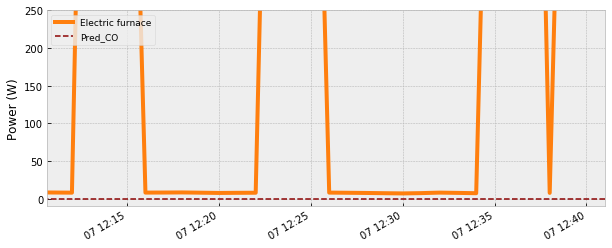

In [53]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Electric furnace'].plot(lw=4, c='tab:orange')
pred_CO['Electric furnace'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Electric furnace','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
#ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

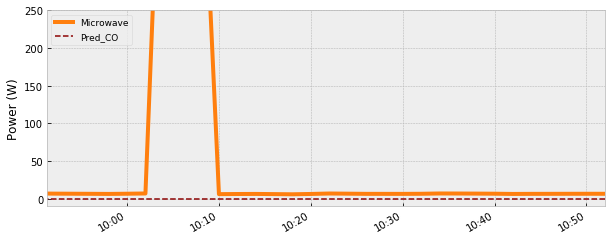

In [54]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Microwave'].plot(lw=4, c='tab:orange')
pred_CO['Microwave'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Microwave','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

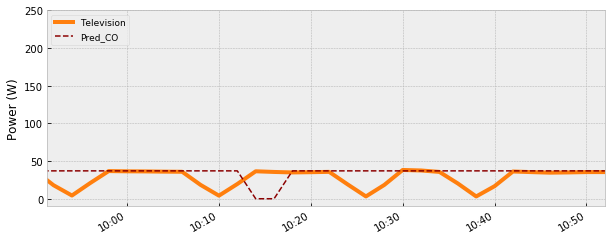

In [55]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Television'].plot(lw=4, c='tab:orange')
pred_CO['Television'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Television','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

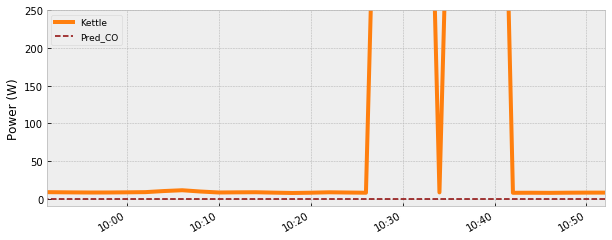

In [56]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Kettle'].plot(lw=4, c='tab:orange')
pred_CO['Kettle'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Kettle','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

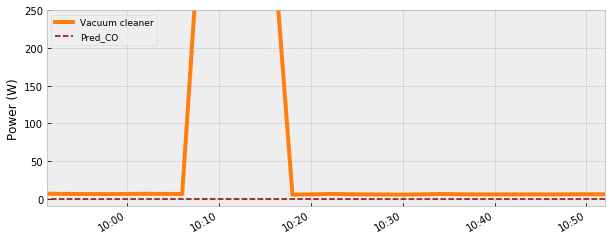

In [57]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Vacuum cleaner'].plot(lw=4, c='tab:orange')
pred_CO['Vacuum cleaner'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Vacuum cleaner','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

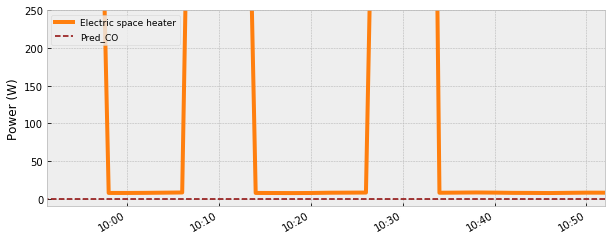

In [58]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Electric space heater'].plot(lw=4, c='tab:orange')
pred_CO['Electric space heater'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Electric space heater','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

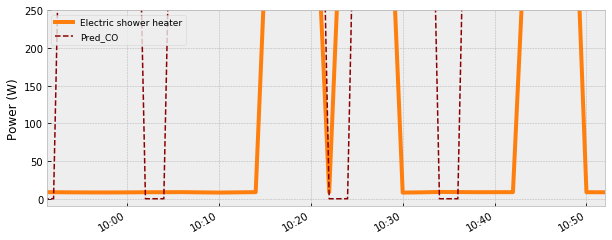

In [59]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo finalfig, ax1 = plt.subplots();
ax1=gt['Electric shower heater'].plot(lw=4, c='tab:orange')
pred_CO['Electric shower heater'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Electric shower heater','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

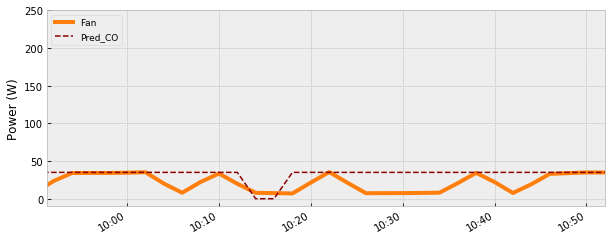

In [60]:
rcParams['figure.figsize'] = (10, 4)

t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Fan'].plot(lw=4, c='tab:orange')
pred_CO['Fan'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Fan','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

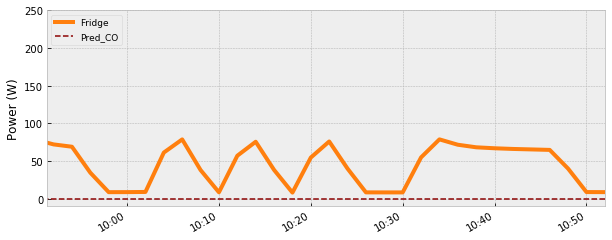

In [61]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Fridge'].plot(lw=4, c='tab:orange')
pred_CO['Fridge'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Fridge','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

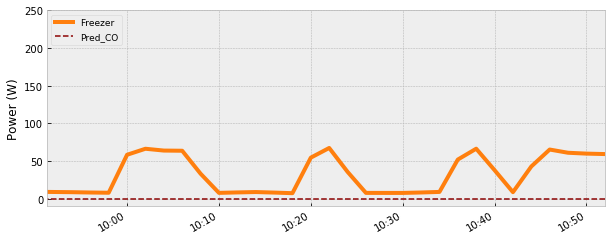

In [62]:
rcParams['figure.figsize'] = (10, 4)
t0='2023-03-07 12:10:38+01:00' #tiempo inicial
t1='2023-03-07 12:41:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['Freezer'].plot(lw=4, c='tab:orange')
pred_CO['Freezer'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['Freezer','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

# Métrica EAE

La ecuación de la figura representa la diferencia entre la energía total asignada yˆt(n) energía total consumida yt(n) por el proceso n de la industria en kWh 

![metricas](metricas.jpg)

In [63]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,Electric furnace,Microwave,Television,Kettle,Vacuum cleaner,Electric space heater,Electric shower heater,Fan,Fridge,Freezer
EAE,0.08,0.1,0.0,0.03,0.04,0.09,0.1,0.0,0.01,0.01


In [64]:
predictions_Devices=elec_CO_30s_mean.submeters()
e1=predictions_Devices[10].total_energy()[0]
e2=valid_Devices[10].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

,kWh
Energy_pred,0.012917
Energy_GT,0.002579
EAE,0.010000


## Métrica MNEAP

Este indicador que representa la ecuacion de la imagen  consta de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) de cada proceso de la industria, por cada intervalo de tiempo t. Después de sumar todas las diferencias de potencia, el resultado es normalizado por el consumo total de la energía del proceso 

![metricas](metricas.jpg)

In [65]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,Electric furnace,Microwave,Television,Kettle,Vacuum cleaner,Electric space heater,Electric shower heater,Fan,Fridge,Freezer
MNEAP,1.18,3.62,0.58,1.71,2.09,1.26,2.28,0.62,0.66,0.74


## Métrica RMSE

Esta métrica de la ecuación de la figura es muy utilizada en la comparaciónn de diversos conjuntos de datos, consiste en el error cuadrático medio de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) del proceso de los applicativos , en cada intervalo de tiempo t .

![metricas](metricas.jpg)

In [66]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,Electric furnace,Microwave,Television,Kettle,Vacuum cleaner,Electric space heater,Electric shower heater,Fan,Fridge,Freezer
RMSE,741.1,312.3,20.6,546.8,218.5,896.9,733.2,17.2,34.1,28.0


## Resultados de todos los modelos

In [67]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = { '60s':60, '5min':60*5, '10min':60*10}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][1:12])
i=0
for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
            print(i)
            i=i+1
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            #da error para FEAC
            #feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met

##Guardamos resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')



Calculando Metricas: CO_60s_first
0

Calculando Metricas: FHMM_60s_first
1

Calculando Metricas: CO_60s_mean
2

Calculando Metricas: FHMM_60s_mean
3

Calculando Metricas: CO_60s_median
4

Calculando Metricas: FHMM_60s_median
5

Calculando Metricas: CO_5min_first
6

Calculando Metricas: FHMM_5min_first
7

Calculando Metricas: CO_5min_mean
8

Calculando Metricas: FHMM_5min_mean
9

Calculando Metricas: CO_5min_median
10

Calculando Metricas: FHMM_5min_median
11

Calculando Metricas: CO_10min_first
12

Calculando Metricas: FHMM_10min_first
13

Calculando Metricas: CO_10min_mean
14

Calculando Metricas: FHMM_10min_mean
15

Calculando Metricas: CO_10min_median
16

Calculando Metricas: FHMM_10min_median
17


Done!


## Otras Metricas: métricas Promedio

In [68]:
m_mean = {}

#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['60s','5min','10min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean()],
                              #CO MEAN
                             [m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean()],
                              #CO MEDIAN
                             [m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean()],
                             #FHMM FIRST
                             [m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean()]],columns=per, index=labels).transpose()
m_mean


{'F1':         CO-first    CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 60s    14.891026  19.047619  15.323635   30.338265  28.922308    30.469332
 5min    0.000000   0.000000   0.000000    0.000000   0.000000     0.000000
 10min   0.000000   0.000000   0.000000    0.000000   0.000000     0.000000,
 'EAE':        CO-first  CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 60s    0.002298      0.0        0.0         0.0        0.0          0.0
 5min   0.089789      0.0        0.0         0.0        0.0          0.0
 10min  0.000000      0.0        0.0         0.0        0.0          0.0,
 'MNEAP':        CO-first   CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 60s    1.100226  1.633348   1.126468    1.474919   1.428646     1.458444
 5min   1.000000  1.000000   1.000000    0.944206   1.013954     0.754083
 10min  1.000000  1.000000   1.000000    0.755476   0.711900     0.797782,
 'RMSE':          CO-first     CO-mean   CO-median  FHMM-first   FHMM-mean  FHMM-me

## Maximos


In [69]:
cols=['F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

,60s,5min,10min
F1,30.47,0.00,0.00
EAE,0.00,0.00,0.00
MNEAP,1.10,0.75,0.71
RMSE,350.77,203.15,125.12


## Correspondencia de Indice

In [70]:
cols=['F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

,60s,5min,10min
F1,FHMM-median,CO-first,CO-first
EAE,CO-mean,CO-mean,CO-first
MNEAP,CO-first,FHMM-median,FHMM-mean
RMSE,FHMM-median,FHMM-mean,FHMM-mean


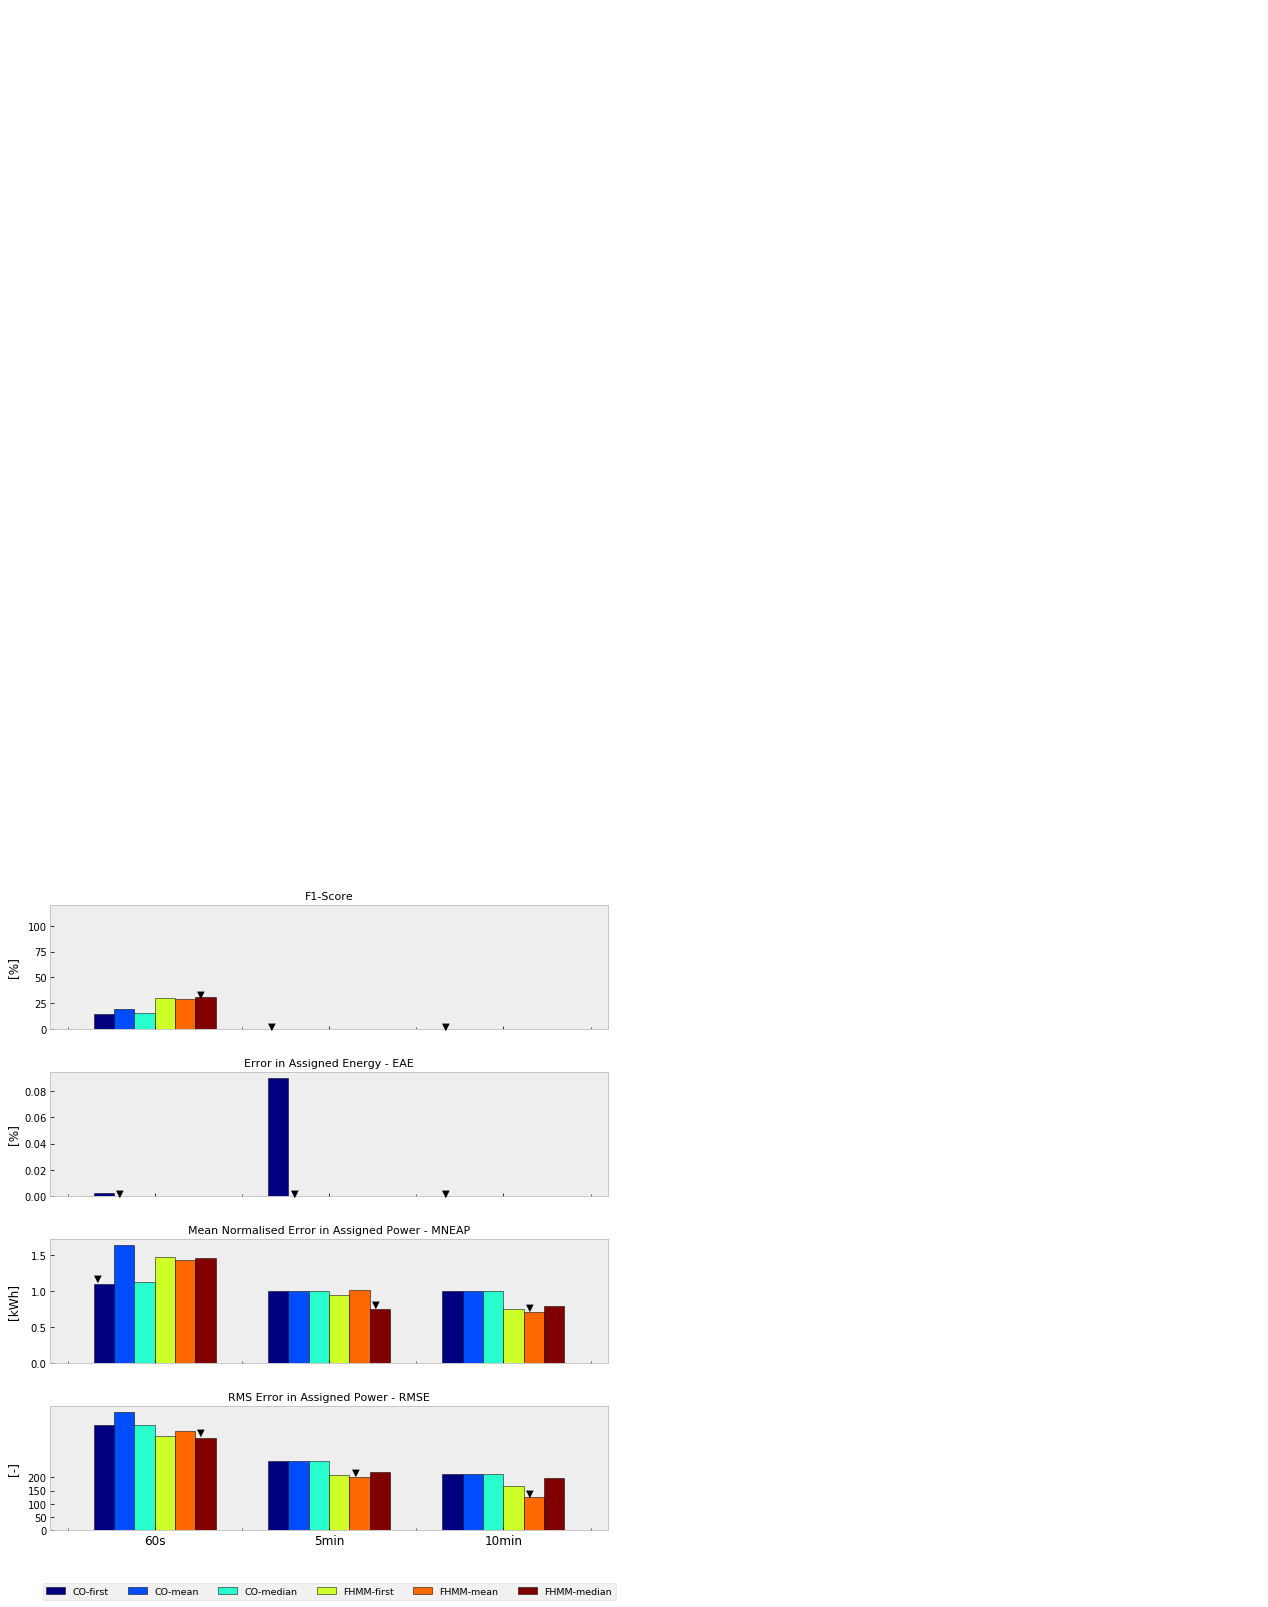

In [71]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['60s','5min','10min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax2,ax3,ax4,ax5)])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])

ax5.set_yticks([0,50,100,150,200])

ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


#ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
#ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
#ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
#ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('./data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

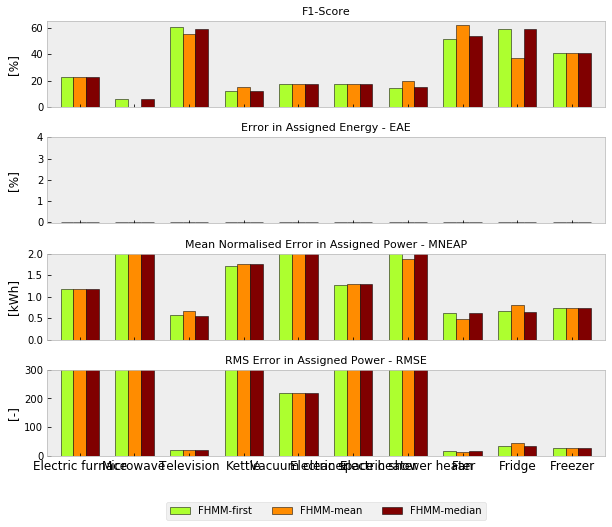

In [72]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})

#cols=['FEAC','F1','EAE','MNEAP','RMSE']
cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']
labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']
c=0

for ax in fig.get_axes():
    
    df=pd.DataFrame([m['60s'][1][cols[c]],m['60s'][3][cols[c]],m['60s'][5][cols[c]]]).transpose()
    #if ax==ax1:
    #    df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    #else:
    #     df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
 
    df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    

ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))


plt.savefig('./data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass


 ## INDICES DEL DATAFRAME

CO_60s_first:0

FHMM_60s_first:1

CO_60s_mean:2

FHMM_60s_mean :3

CO_60s_median:4

FHMM_60s_median:5


------------------------------


CO_5min_first:6

FHMM_5min_first:7

CO_5min_mean:8

FHMM_5min_mean:9

CO_5min_median:10

 FHMM_5min_median:11


----------------------------


CO_10min_first:12

FHMM_10min_first:13

CO_10min_mean:14

FHMM_10min_mean :15

CO_10min_median:16

FHMM_10min_median:17

In [82]:
print('FHMM-first')
print(m['60s'][1])
print('\nFHMM-mean')
print(m['60s'][3])
print('\nFHMM-median')
print(m['60s'][5])

FHMM-first
                               F1  EAE     MNEAP        RMSE
Electric furnace        22.857143  0.0  1.184769  741.077638
Microwave                6.250000  0.0  3.618023  312.332853
Television              60.606061  0.0  0.575570   20.632955
Kettle                  12.121212  0.0  1.714388  546.772974
Vacuum cleaner          17.647059  0.0  2.094413  218.454374
Electric space heater   17.647059  0.0  1.257810  896.856694
Electric shower heater  14.285714  0.0  2.274746  733.202696
Fan                     51.851852  0.0  0.622918   17.189617
Fridge                  59.090909  0.0  0.664277   34.146129
Freezer                 41.025641  0.0  0.742273   28.029413

FHMM-mean
                               F1  EAE     MNEAP        RMSE
Electric furnace        22.857143  0.0  1.186514  740.492061
Microwave                0.000000  0.0  3.362938  457.832730
Television              55.555556  0.0  0.671775   21.540560
Kettle                  15.384615  0.0  1.751466  741.205415
Va

### Resultados del mejor modelo
En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 30 segundos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 30 segundos.

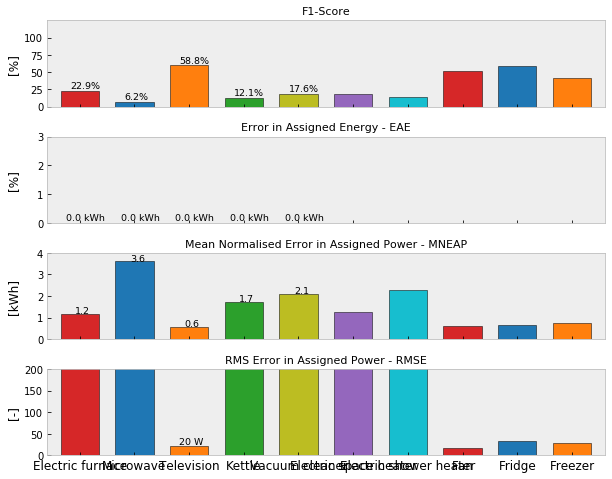

In [83]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})
#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['60s'][1][cols[c]])
    df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1


ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})

fig.align_ylabels([(ax2,ax3,ax4,ax5)])

ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

ax2.set_yticks([0,25,50,75,100])
ax3.set_yticks([0,1,2,3])
ax4.set_yticks([0,1,2,3,4])
ax5.set_yticks([0,50,100,150,200])


ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['60s'][5])

for x in range(5):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(5):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(5):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(5):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('./data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)

In [84]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=11, building=1, dataset='DSUAL') ...   total_energy for ElecMeterID(instance=8, building=1, dataset='DSUAL') ...    total_energy for ElecMeterID(instance=9, building=1, dataset='DSUAL') ...   

reactive    0.028278
apparent    0.956737
active      0.952033
dtype: float64

In [85]:
valid_Devices.energy_per_meter()

10/10 ElecMeter(instance=11, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

,"(2, 1, DSUAL)","(3, 1, DSUAL)","(4, 1, DSUAL)","(5, 1, DSUAL)","(6, 1, DSUAL)","(7, 1, DSUAL)","(8, 1, DSUAL)","(9, 1, DSUAL)","(10, 1, DSUAL)","(11, 1, DSUAL)"
active,0.272788,0.041722,0.014019,0.132325,0.047624,0.274191,0.118936,0.01103,0.02304,0.016357
apparent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Replicando el entrenamiento del modelo

In [86]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM


train = DataSet('dsual.h5')

train.set_window(start="2023-03-07 11:10:38", end="2023-03-07 12:10:00")
train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])

#opcional: asignación manual de estados de dispositivos
#num_states={train_Devices[2]:2, train_Devices[3]:3, train_Devices[4]:4,
#            train_Devices[5]:5, train_Devices[6]:6}

#entrenamiento y exportación del modelo
FHMM_30s_median=FHMM()
FHMM_30s_median.MIN_CHUNK_LENGTH=1
FHMM_30s_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})


#falla aqui al exportar el modelo
#FHMM_30min_median.export_model('./data/FHMM_30s_median_model.pickle') 
#output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')


print('\n\nDone!')


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='kettle', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='DSUAL', appl

In [87]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM()
#FHMM.import_model('C:/data/FHMM_30s_median_model.pickle') 
print('Oven: '+str(FHMM_30s_median.individual[valid_Devices[2]].means_))
print('Microwave: '+str(FHMM_30s_median.individual[valid_Devices[3]].means_))
print('Television: '+str(FHMM_30s_median.individual[valid_Devices[4]].means_))
print('Kettle: '+str(FHMM_30s_median.individual[valid_Devices[5]].means_))
print('Vacuum Cleaner: '+str(FHMM_30s_median.individual[valid_Devices[6]].means_))

print('electric space heater: '+str(FHMM_30s_median.individual[valid_Devices[7]].means_))
print('electric shower heater: '+str(FHMM_30s_median.individual[valid_Devices[8]].means_))
print('Fan: '+str(FHMM_30s_median.individual[valid_Devices[9]].means_))
print('Fridge: '+str(FHMM_30s_median.individual[valid_Devices[10]].means_))
print('Freezer: '+str(FHMM_30s_median.individual[valid_Devices[11]].means_))

Oven: [[8.42022292]]
Microwave: [[6.93598286]]
Television: [[25.17810504]]
Kettle: [[8.86301327]]
Vacuum Cleaner: [[6.55046384]]
electric space heater: [[8.58766969]]
electric shower heater: [[390.96100966]]
Fan: [[8.19169585]]
Fridge: [[9.16555341]]
Freezer: [[8.20585855]]


In [88]:
FHMM_30s_median.model

GaussianHMM(covariance_type='full')

In [89]:
FHMM_30s_median.individual

OrderedDict([(ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='kettle', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])